# A Beginner’s Guide to Carry out Extreme Value Analysis (4) - DDF

Intensity Duration Frequency (IDF) or Depth Duration Frequency (DDF) curves are among the most common tools used in water resources management. They are derived from historical rainfall records under the assumption of stationarity. Rainfall IDF/DDF curve information describes the frequency of extreme rainfall events for a variety of durations and intensities.

The following presents a primary procedure to create DDF curves.

## 1. Load precipitation data
This is a hourly data precipitation data. The data have been convert to annual maxima time series for the durations of 1h, 3h, 6h, 12h, and 24h.

In [1]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime

%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 9

In [2]:
data = pd.read_csv('PluviometriaPaperopoli_4.txt')
data=data.set_index('anno')
data.head()

,1h,3h,6h,12h,24h
anno,,,,,
1925,50.0,NaN,NaN,NaN,NaN
1928,35.0,47.0,50.0,50.4,67.6
1929,35.4,36.4,36.4,49.6,74.0
1930,67.2,68.2,80.8,102.2,106.8
1931,25.2,NaN,NaN,NaN,NaN


In the data, the 1h, 3h, 6h, 12h and 24h are the durations, which is also the accumulatin time for precipitation.

### Have a simple check for each duration.

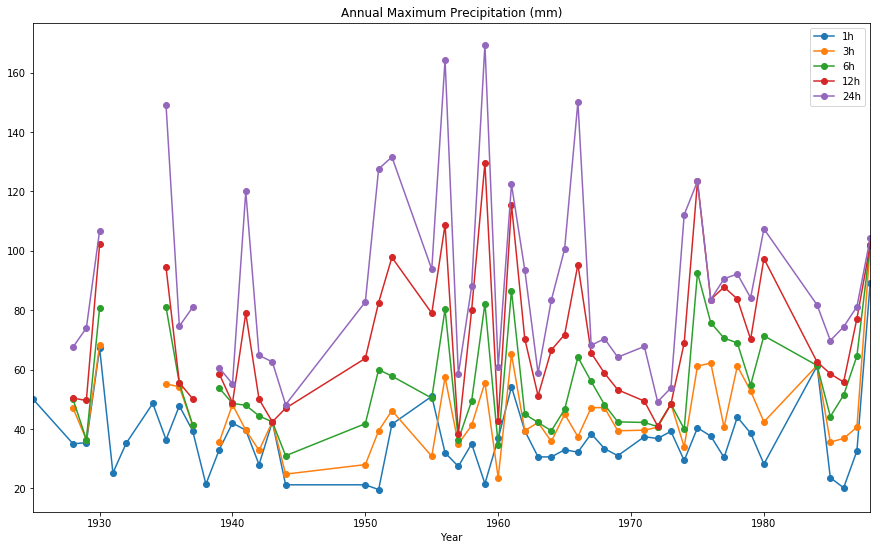

In [3]:
ax = data.plot(title="Annual Maximum Precipitation (mm)", style="o-")
ax.set_xlabel("Year")


## 2. Carry out extreme value analysis for each duration

This is a primary step that has been shown before (part 2). For the purpose of illustration, the GUM parameters are used for further analysis.

In [4]:
import lmoments
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from statsmodels.distributions.empirical_distribution import ECDF
from collections import OrderedDict

### Fit Gumble distribution for each duration

In [5]:
gumfit = OrderedDict()
for name in data.columns.values.tolist():     
    dx = (data[name]).dropna()    
    gumfit[name] = lmoments.pelgum(lmoments.samlmu(dx) )  

lmoments\lmoments.py:235: RuntimeWarning: overflow encountered in double_scalars
  obj+obj, obj-obj, obj*obj, obj**obj, obj/obj


### Sample each time series

In [6]:
samples = np.linspace(data.min()[0],data.max()[4],100)

### Convert samples into probabilities

In [7]:
samprobs = pd.DataFrame([lmoments.cdfgum(samples, gumfit["1h"]),
                         lmoments.cdfgum(samples, gumfit["3h"]),
                         lmoments.cdfgum(samples, gumfit["6h"]),
                         lmoments.cdfgum(samples, gumfit["12h"]),
                         lmoments.cdfgum(samples, gumfit["24h"])]).T
samprobs.index = samples
samprobs.columns=["1h","3h","6h","12h","24"]

lmoments\_otherfunct.py:9: RuntimeWarning: overflow encountered in power
  obj+obj, obj-obj, obj*obj, obj**obj, obj/obj


### Compare with observations

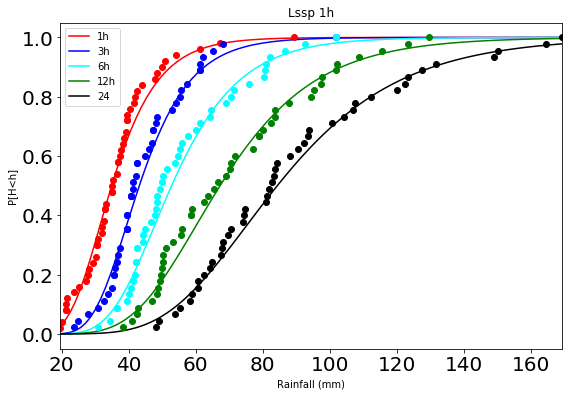

In [8]:
rcParams['figure.figsize'] = 9, 6

plt.rc('xtick', labelsize=20) #Quest  comandi globali
plt.rc('ytick', labelsize=20) #Questi sono comandi globali
ax = samprobs.plot(color=["red","blue","cyan","green","black"])

ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"],ecdf1h(data["1h"]),'o',c="red",label="1h")

data3h = data["3h"].dropna()
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"o",c="blue",label="3h")

data6h = data["6h"].dropna()
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"o",c="cyan")

data12h=data["12h"].dropna()
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"o",c="green")

data24h=data["24h"].dropna()
ecdf24h = ECDF(data24h)

ax.plot(data24h,ecdf24h(data24h),"o",c="black")
ax.set_title('Lssp 1h')
ax.set_xlabel('Rainfall (mm)')
ax.set_ylabel('P[H<h]')

## 3. Fit extreme precipitation into theorectical DDF curve for each return year

### Setup some return years (e.g., 2, 10, 20, 50, 100, 200)

In [9]:
q2   = 1-1/2.
q10  = 1-1/10.
q20  = 1-1/20.
q50  = 1-1/50.
q100 = 1-1/100.
q200 = 1-1/200.

q = [q2,q10,q20,q50, q100, q200]

### Calculate extreme values for return years and durations

In [10]:
samprobs = OrderedDict()

for name in gumfit.keys():
    samprobs[name] = lmoments.quagum(q, gumfit[name])    

pts = pd.DataFrame.from_dict(samprobs, orient='index')
pts.columns=[2,10,20,50, 100, 200]
pts

,2,10,20,50,100,200
1h,34.948911,52.500529,59.207069,67.887998,74.393132,80.874530
3h,43.200454,62.508559,69.886259,79.435935,86.592073,93.722100
6h,52.825522,78.426358,88.208535,100.870559,110.358964,119.812748
12h,67.284215,103.407161,117.209876,135.076075,148.464276,161.803627
24h,84.354600,130.616964,148.293989,171.175085,188.321246,205.404844


#### convert index into numbers as axis of plotting

In [11]:
pts.index = [1,3,6,12,24]
pts

,2,10,20,50,100,200
1,34.948911,52.500529,59.207069,67.887998,74.393132,80.874530
3,43.200454,62.508559,69.886259,79.435935,86.592073,93.722100
6,52.825522,78.426358,88.208535,100.870559,110.358964,119.812748
12,67.284215,103.407161,117.209876,135.076075,148.464276,161.803627
24,84.354600,130.616964,148.293989,171.175085,188.321246,205.404844


(30, 200)

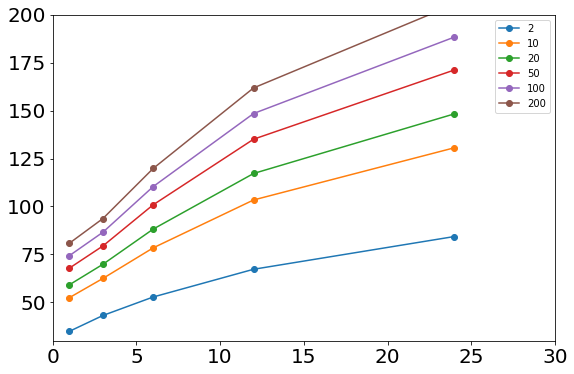

In [12]:
pts.plot(style="o-")
plt.xlim([0,30])
plt.ylim([30,200])

(30, 200)

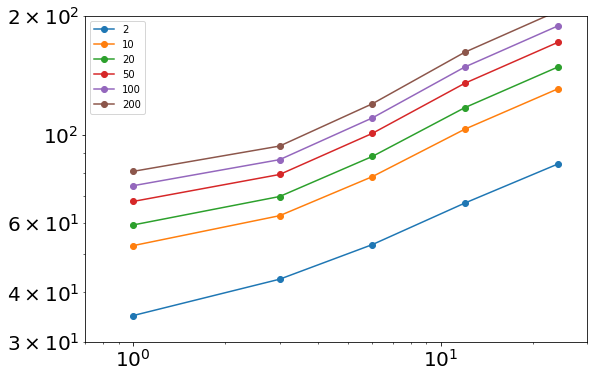

In [13]:
ag = pts.plot(style="o-")
ag.set_yscale('log')
ag.set_xscale('log')
plt.xlim([0,30])
plt.ylim([30,200])
plt.xlim([0.7,30])
plt.ylim([30,200])

### The simplest DDF curve formula is like

$$ h(t_p, Tr) = a(T_r) t_p^n$$
$$\log h(t_p, Tr) = \log a(T_r) + n \log t_p $$

### Fit DDF curves based the above formula
numpy.polyfit is used to fit the above curve for each return year in 10, 20 and 100 years.

In [14]:
ddfparams = OrderedDict()
for name in pts.columns.values.tolist(): 
    ddfparams[name] = np.polyfit(np.log(pts[name].index),np.log(pts[name]),1)
    ddfparams[name][1] = np.exp( ddfparams[name][1])

fnl = pd.DataFrame.from_dict(ddfparams, orient='index')
fnl.columns=["n","a"]
fnl   

,n,a
2,0.281161,33.286954
10,0.295041,48.868336
20,0.298152,54.823397
50,0.301259,62.532122
100,0.303110,68.308979
200,0.304656,74.064909


### Setup some durations for interpolation and plotting (<=30 hours)

In [15]:
samdurations = np.linspace(0.1,30,100)
samdurations[-5:]

array([ 28.79191919,  29.09393939,  29.3959596 ,  29.6979798 ,  30.        ])

### Use the ddf regression parameters to calculate ddf values

In [16]:
def regddf(duration, intercepta, expn):
    return intercepta*duration**expn

In [17]:
fnlt = fnl.T

ddfvalues = OrderedDict()
for name in pts.columns.values.tolist():     
    ddfvalues[name] = regddf(samdurations,fnlt[name]["a"],fnlt[name]["n"])
    
inh = pd.DataFrame.from_dict(ddfvalues, orient='index').T.set_index(samdurations) 

#### set a understandable column names

In [18]:
inh.columns = ["Tr = 2","Tr = 10","Tr = 20","Tr = 50","Tr = 100", "Tr = 200"]

#### Have a visualization check

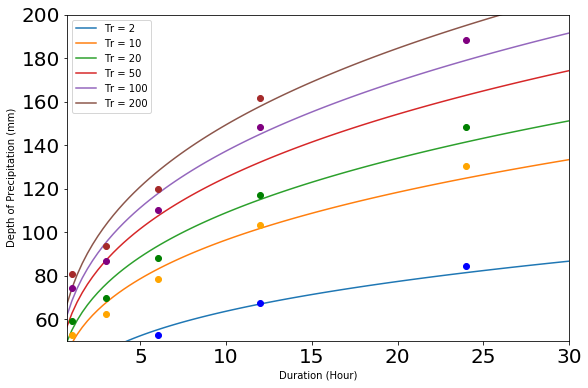

In [19]:
ag = inh.plot()

ag = plt.plot(pts[2],  "o", color="blue")
ag = plt.plot(pts[10], "o", color="orange")
ag = plt.plot(pts[20], "o", color="green")
ag = plt.plot(pts[100],"o", color="purple")
ag = plt.plot(pts[200],"o", color="brown")

plt.xlim([0.7,30])
plt.ylim([50,200])

plt.xlabel("Duration (Hour)")
plt.ylabel("Depth of Precipitation (mm)")

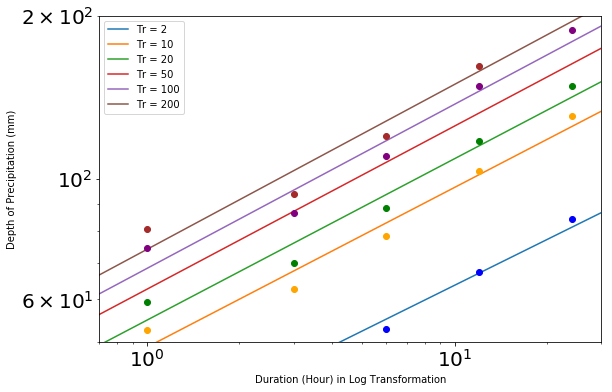

In [20]:
ag = inh.plot()
ag.set_yscale('log')
ag.set_xscale('log')

ag = plt.plot(pts[2],  "o", color="blue")
ag = plt.plot(pts[10], "o", color="orange")
ag = plt.plot(pts[20], "o", color="green")
ag = plt.plot(pts[100],"o", color="purple")
ag = plt.plot(pts[200],"o", color="brown")

plt.xlim([0.7,30])
plt.ylim([50,200])

plt.xlabel("Duration (Hour) in Log Transformation")
plt.ylabel("Depth of Precipitation (mm)")

## End Notes

Through this guide I have tried to give you a basic idea how to carry out extreme value analysis (EVA) upon a time series data of interest.

In fact, the analysis will become more complicated in a real practice as high quality data are not always available. Sometimes, you have to spend a lot of time cleaning the data. For example, fill the missing values and check outliers.

In addition, carrying out EVA always fits several distributions, simultaneouly. Then a goodness-of-fit measure (e.g., Anderson-Darling test) is used to select the optimal one.

This is just a start. You can try more.